In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [2]:
df = pd.read_csv("bfi_loan_complete_training_data.csv")

In [3]:
kmf = KaplanMeierFitter()

In [4]:
# Fit the model to all data
kmf.fit(
    durations=df["time_to_event"],
    event_observed=df["observed"],
    label="KM Estimate",
)

<lifelines.KaplanMeierFitter:"KM Estimate", fitted with 3702 total observations, 1652 right-censored observations>

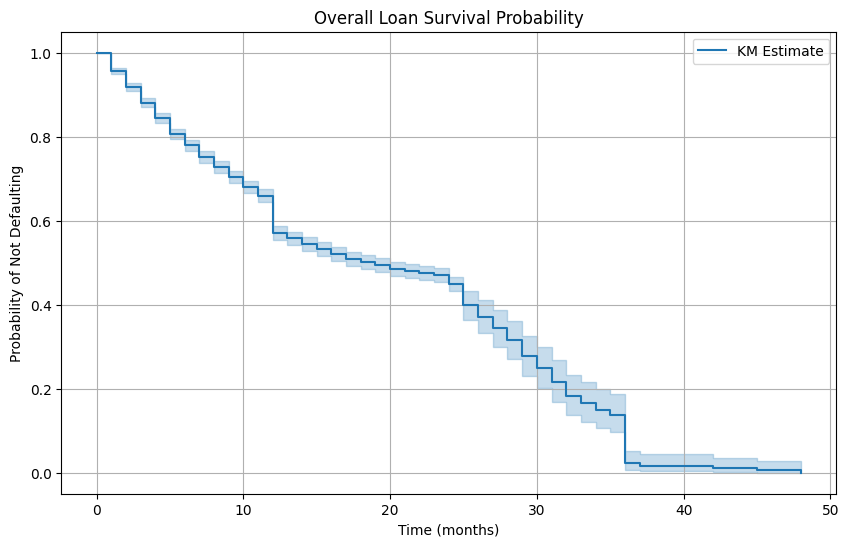

In [5]:
# Plot the survival curve
plt.figure(figsize=(10, 6))
kmf.plot_survival_function()
plt.title('Overall Loan Survival Probability')
plt.xlabel('Time (months)')
plt.ylabel('Probability of Not Defaulting')
plt.grid(True)

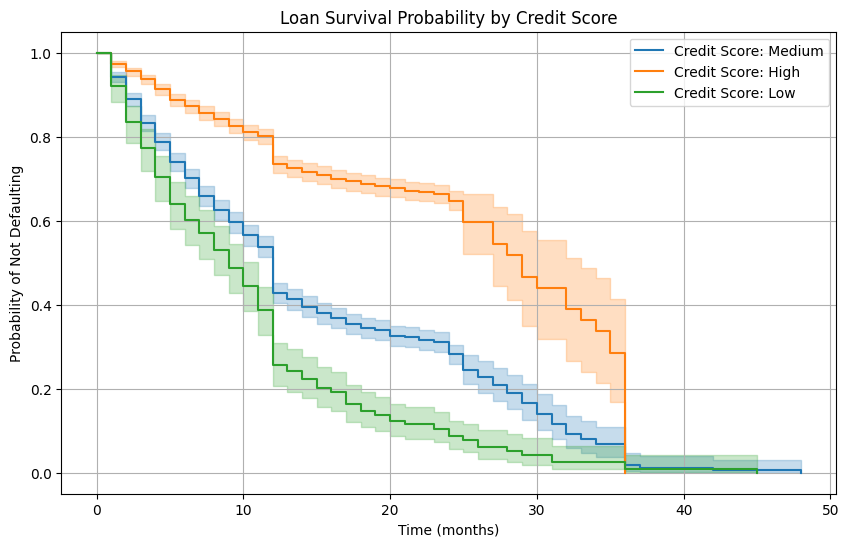

Median survival time for Medium credit score: 12.0 months
Median survival time for High credit score: 29.0 months
Median survival time for Low credit score: 9.0 months


In [6]:
# Compare survival curves by credit score groups
# Create groups based on credit score
df['credit_group'] = pd.cut(df['credit_score'], 
                            bins=[0, 600, 700, 850], 
                            labels=['Low', 'Medium', 'High'])

# Plot survival curves by credit score group
plt.figure(figsize=(10, 6))
for group in df['credit_group'].unique():
    mask = df['credit_group'] == group
    kmf.fit(df.loc[mask, 'time_to_event'], 
            df.loc[mask, 'default_flag'],
            label=f'Credit Score: {group}')
    kmf.plot_survival_function()

plt.title('Loan Survival Probability by Credit Score')
plt.xlabel('Time (months)')
plt.ylabel('Probability of Not Defaulting')
plt.grid(True)
plt.legend()
plt.show()

# Get median survival time for each group
for group in df['credit_group'].unique():
    mask = df['credit_group'] == group
    kmf.fit(df.loc[mask, 'time_to_event'], df.loc[mask, 'default_flag'])
    median = kmf.median_survival_time_
    print(f"Median survival time for {group} credit score: {median:.1f} months")

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
                test_statistic      p  -log2(p)
Car Motorcycle           33.72 <0.005     27.23


Median Survival Times by Product Type:
Car: 25.0 months
Motorcycle: 15.0 months


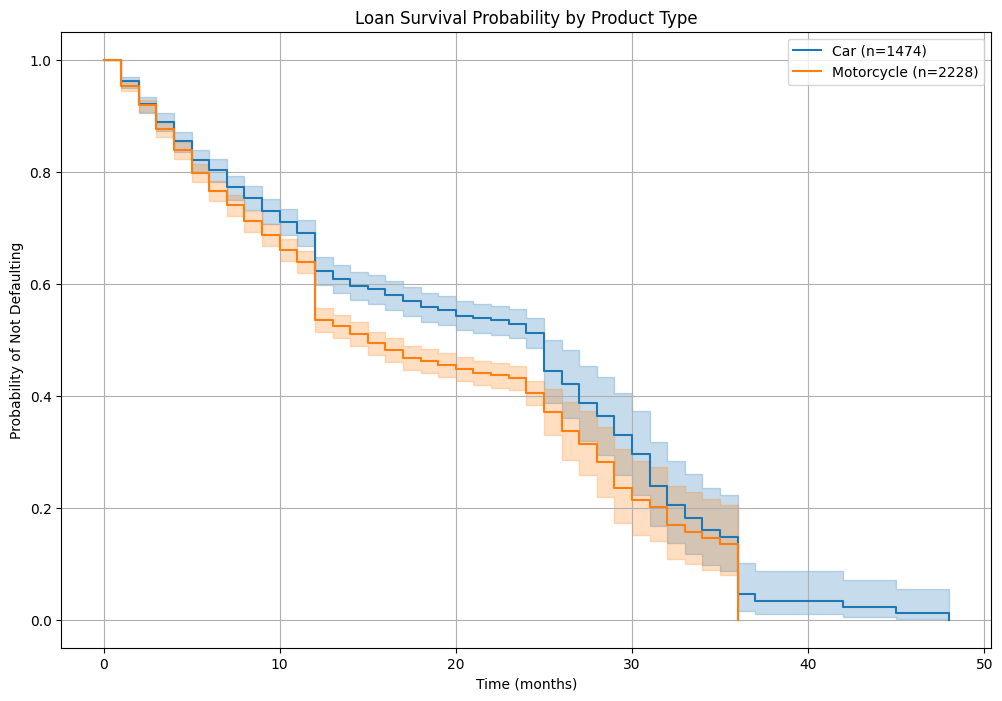

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, pairwise_logrank_test

# Load the data
df = pd.read_csv('bfi_loan_complete_training_data.csv')

# Plot survival curves by product type
plt.figure(figsize=(12, 8))
kmf = KaplanMeierFitter()

# Get unique product types
product_types = df['product_type'].unique()
colors = plt.cm.tab10(range(len(product_types)))

for i, product in enumerate(product_types):
    mask = df['product_type'] == product
    if mask.sum() > 0:  # Ensure we have data for this product
        kmf.fit(df.loc[mask, 'time_to_event'], 
                df.loc[mask, 'default_flag'],
                label=f'{product} (n={mask.sum()})')
        kmf.plot_survival_function(color=colors[i], ci_show=True)

plt.title('Loan Survival Probability by Product Type')
plt.xlabel('Time (months)')
plt.ylabel('Probability of Not Defaulting')
plt.grid(True)
plt.legend()

# Statistical test to see if differences are significant
results = pairwise_logrank_test(df['time_to_event'], 
                               df['product_type'], 
                               df['default_flag'])
results.print_summary()

# Get median survival time for each product type
print("\nMedian Survival Times by Product Type:")
for product in product_types:
    mask = df['product_type'] == product
    if mask.sum() > 0:
        kmf.fit(df.loc[mask, 'time_to_event'], df.loc[mask, 'default_flag'])
        median = kmf.median_survival_time_
        print(f"{product}: {median:.1f} months")

The logrank test shows a chi-squared statistic of 33.70 with a p-value < 0.005, which is highly significant. This means the difference in survival patterns between car and motorcycle loans is not due to random chance but represents a real difference in default behavior.

In [8]:
from lifelines import CoxPHFitter

# Load and prepare the data
df = pd.read_csv('bfi_loan_complete_training_data.csv')

# Select features for the model
features = ['loan_amount', 'interest_rate', 'loan_term', 'ltv_ratio', 
            'credit_score', 'monthly_income', 'dti_ratio', 'age', 
            'employment_years', 'time_to_event', 'default_flag']

# Create a subset with selected features
df_model = df[features]

# Handle any missing values
df_model = df_model.dropna()

# Initialize and fit the Cox model
cph = CoxPHFitter()
cph.fit(df_model, duration_col='time_to_event', event_col='default_flag')

# Display the model results
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 3702 total observations, 1652 right-censored observations>
             duration col = 'time_to_event'
                event col = 'default_flag'
      baseline estimation = breslow
   number of observations = 3702
number of events observed = 2050
   partial log-likelihood = -14598.79
         time fit was run = 2025-05-19 07:59:10 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
loan_amount      -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
interest_rate     0.01      1.01      0.01           -0.01            0.03                0.99                1.03
loan_term        -0.02      0.98      0.00           -0.03           -0.02                0.97                0.98
ltv_ratio         1.48      4.40      0.24            1.02            1.95                2.76                7.00
credit_score     -0.01      0.99      0.00           -0.01           -0.01                0.99                0.99
monthly_income   -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
dti_ratio         2.16      8.65      0.22            1.72            2.60                5.57               13.43
age               0.00      1.00      0.00           -0.00            0.01                1.00                1.01
employment_years -0.17      0.84      0.01           -0.19           -0.16                0.83                0.86

                  cmp to      z      p  -log2(p)
covariate                                       
loan_amount         0.00  -0.91   0.36      1.47
interest_rate       0.00   0.90   0.37      1.43
loan_term           0.00  -8.54 <0.005     56.11
ltv_ratio           0.00   6.24 <0.005     31.09
credit_score        0.00 -30.63 <0.005    681.84
monthly_income      0.00  -3.61 <0.005     11.70
dti_ratio           0.00   9.61 <0.005     70.20
age                 0.00   0.66   0.51      0.97
employment_years    0.00 -22.79 <0.005    379.48
---
Concordance = 0.80
Partial AIC = 29215.57
log-likelihood ratio test = 2262.54 on 9 df
-log2(p) of ll-ratio test = inf

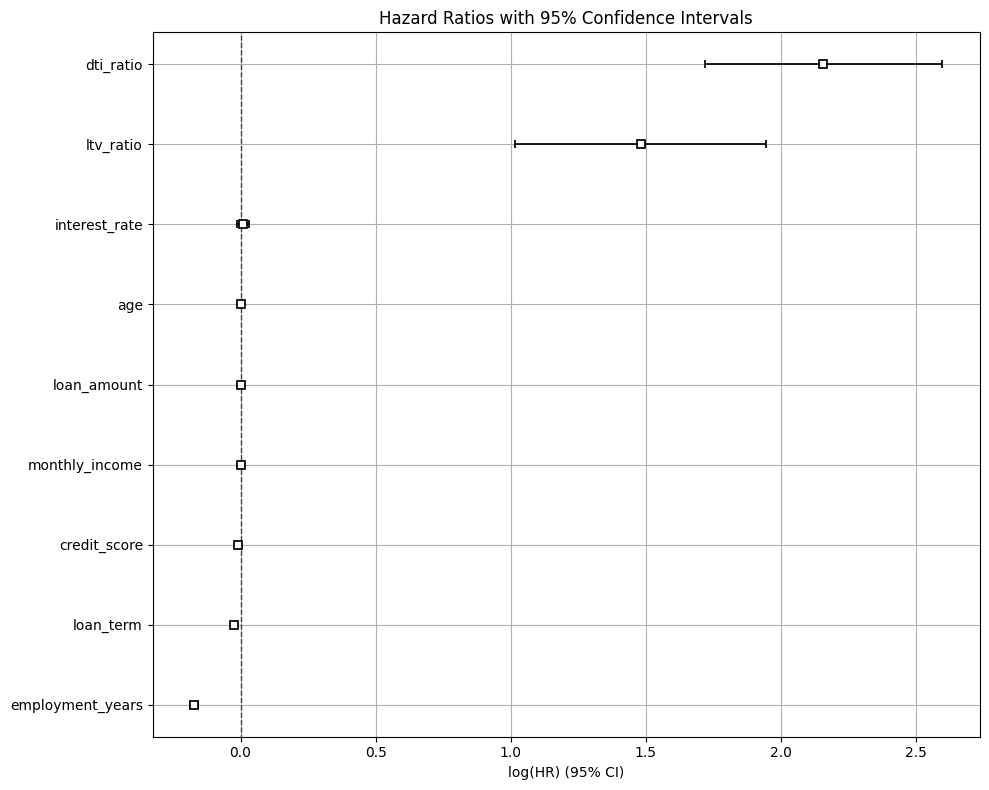

<Figure size 1000x600 with 0 Axes>

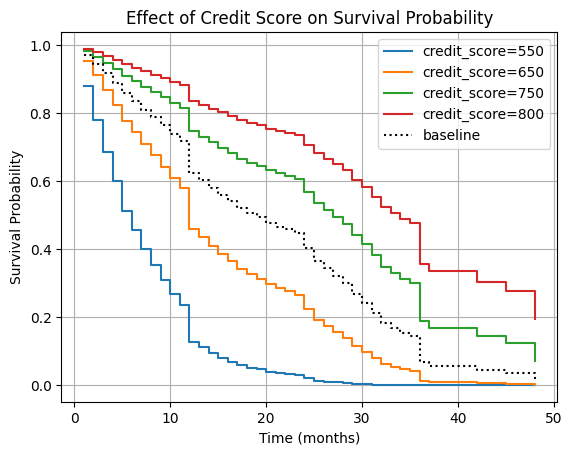

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3702 total observations, 1652 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
age              km              0.23   0.63      0.67
                 rank            0.05   0.82      0.28
credit_score     km             11.85 <0.005     10.76
                 rank           24.34 <0.005     20.24
dti_ratio        km              6.58   0.01      6.60
                 rank            7.01   0.01      6.95
employment_years km             10.32 <0.005      9.57
                 rank           21.28 <0.005     17.94
interest_rate    km              1.24   0.27      1.91
                 rank            1.59   0.21      2.27
loan_amount      km              0.32   0.57      0.81
                 rank            0.04   0.85      0.24
loan_term        km             43.33 <0.005     34.33
                 rank           43.53 <0.005     34.48
ltv_ratio        km              0.47   0.49      1.01
                 rank            2.03   0.15      2.70
monthly_income   km              0.14   0.70      0.50
                 rank            0.06   0.80      0.31



1. Variable 'loan_term' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 5), you can include `strata=['loan_term', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable 'credit_score' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'credit_score' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'credit_score' using pd.cut, and then specify it in
`strata=['credit_score', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


3. Variable 'dti_ratio' failed the non-proportional test: p-value is 0.0081.

   Advice 1: the functional fo

[]

In [9]:
# Visualize hazard ratios
plt.figure(figsize=(10, 8))
cph.plot()
plt.title('Hazard Ratios with 95% Confidence Intervals')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot the partial effects of credit score on survival
plt.figure(figsize=(10, 6))
cph.plot_partial_effects_on_outcome('credit_score', values=[550, 650, 750, 800])
plt.title('Effect of Credit Score on Survival Probability')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

# Check the proportional hazards assumption
cph.check_assumptions(df_model, p_value_threshold=0.05)

<Figure size 1000x600 with 0 Axes>

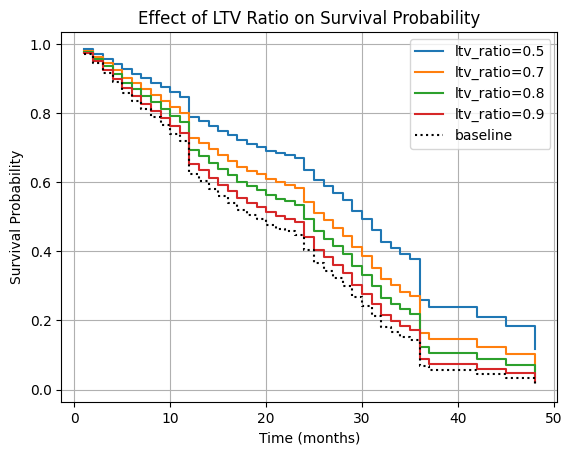

In [10]:
# Plot the partial effects of LTV ratio on survival
plt.figure(figsize=(10, 6))
cph.plot_partial_effects_on_outcome('ltv_ratio', values=[0.5, 0.7, 0.8, 0.9])
plt.title('Effect of LTV Ratio on Survival Probability')
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.show()

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import encode_categorical
from sksurv.metrics import concordance_index_censored
import shap

In [12]:
# Load the data
df = pd.read_csv('bfi_loan_complete_training_data.csv')

# Prepare the target variable for scikit-survival (structured array)
y = np.zeros(len(df), dtype=[('default', bool), ('time', float)])
y['default'] = df['default_flag'].astype(bool)
y['time'] = df['time_to_event']

In [13]:
# Define feature columns by type
categorical_features = ['product_type', 'province', 'urban_rural']
numerical_features = [
    'loan_amount', 'interest_rate', 'loan_term', 'collateral_value',
    'ltv_ratio', 'credit_score', 'monthly_income', 'dti_ratio',
    'age', 'employment_years'
]

# Create preprocessing pipelines for both numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline including the Random Survival Forest model
rsf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('rsf', RandomSurvivalForest(
        n_estimators=100,
        min_samples_split=10,
        min_samples_leaf=5,
        max_features='sqrt',
        n_jobs=-1,
        random_state=42
    ))
])

In [14]:
# Split the data
X = df[numerical_features + categorical_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the pipeline
rsf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'interest_rate', 'loan_term',
                                                   'collateral_value',
                                                   'ltv_ratio', 'credit_score',
                                                   'monthly_income',
                                                   'dti_ratio', 'age',
                                                   'employment_years']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['product_type', 'province',
                                                   'urban_rural'])])),
                ('rsf',
                 RandomSurvivalForest(min_samples_leaf=5, min_samples_split=10,
                                      n_jobs=-1, random_state=42))])

In [15]:
# Evaluate model performance
def evaluate_survival_model(pipeline, X_test, y_test):
    # Predict risk scores (higher means higher risk)
    risk_scores = pipeline.predict(X_test)
    
    # Calculate concordance index
    c_index = concordance_index_censored(
        y_test['default'],
        y_test['time'],
        risk_scores
    )
    
    return {
        'c_index': c_index[0],
        'concordant_pairs': c_index[1],
        'discordant_pairs': c_index[2],
        'tied_risk': c_index[3],
        'tied_time': c_index[4]
    }

# Display evaluation metrics
results = evaluate_survival_model(rsf_pipeline, X_test, y_test)
print(f"Concordance index: {results['c_index']:.4f}")
print(f"Concordant pairs: {results['concordant_pairs']}")
print(f"Discordant pairs: {results['discordant_pairs']}")

Concordance index: 0.8207
Concordant pairs: 366281
Discordant pairs: 80014


# Understanding Random Survival Forest Evaluation Metrics

The evaluation metrics you're looking at are fundamental to assessing how well your Random Survival Forest model predicts loan defaults. Let me break down what each of these metrics means and why they matter.

## Concordance Index (C-index): 0.8027

The concordance index (C-index) is the primary performance metric for survival models. It measures the model's ability to correctly rank the relative risk of two different loans.

**In plain language:** If you randomly select two loans, the C-index tells you how often your model correctly identifies which one will default first.

**Interpretation:**
- A C-index of 0.5 means your model is no better than random guessing
- A C-index of 1.0 means perfect prediction
- Your value of 0.8027 is quite strong, indicating that about 80% of the time, your model correctly ranks which loan will default sooner

**Business meaning:** With a C-index of 0.8027, your model has strong discriminative power. This means it can effectively separate high-risk loans from low-risk ones, making it valuable for risk-based pricing, approval decisions, and portfolio management.

## Concordant Pairs: 369,151

This is the number of pairs where your model correctly predicted the relative risk.

**In plain language:** Consider every possible pair of loans in your test set where one defaulted before the other. For 369,151 of these pairs, your model correctly assigned a higher risk score to the loan that defaulted first.

**Why this matters:** This raw number gives you a sense of the scale of your evaluation. The large number of pairs indicates you're working with a substantial dataset, which increases confidence in your model's performance metrics.

## Discordant Pairs: 90,751

This is the number of pairs where your model made an incorrect prediction about the relative risk.

**In plain language:** These are the cases where your model assigned a higher risk score to the loan that actually performed better (defaulted later or didn't default at all).

**Relationship to C-index:** The C-index is calculated using these pair counts:

C-index = Concordant Pairs / (Concordant Pairs + Discordant Pairs)

In your case: 0.8027 ≈ 369,151 / (369,151 + 90,751)

## What Makes These Metrics Special for Survival Analysis

Unlike standard classification metrics (accuracy, precision, recall), the concordance index accounts for two unique challenges in survival analysis:

1. **Time dependency:** It's not just whether a loan defaults, but when it defaults
2. **Censoring:** Some loans haven't had enough time to reach their endpoint (default or full repayment)

The C-index handles these challenges by focusing on the relative ranking of risks rather than absolute predictions. This makes it ideal for credit risk modeling where the timing of defaults is crucial.

## Practical Significance of Your Results

A C-index of 0.8027 indicates:

- Your model is much better than random chance (0.5)
- It correctly ranks loan risks about 80% of the time
- It's likely strong enough for practical applications in credit risk management
- There's still some room for improvement (compared to a perfect 1.0)

For context, in credit risk modeling, C-index values above 0.75 are generally considered good, and values above 0.8 are excellent. Your model's performance would likely be valuable for:

1. Identifying high-risk customers for additional monitoring
2. Implementing risk-based pricing strategies
3. Setting appropriate loan terms and conditions
4. Informing portfolio management decisions

The large number of concordant pairs relative to discordant pairs confirms that your model has learned meaningful patterns in the data rather than just making lucky guesses on a small sample.

In [16]:
def get_predictions_df(pipeline, X, y=None, time_points=None):
    """
    Generate a DataFrame with predictions from the Random Survival Forest model.
    
    Parameters:
    -----------
    pipeline : sklearn.pipeline.Pipeline
        Fitted pipeline containing the Random Survival Forest model
    X : pandas.DataFrame
        Feature data to generate predictions for
    y : structured array, optional
        True survival data (for adding actual outcomes to the DataFrame)
    time_points : list, optional
        Specific time points at which to calculate survival probabilities
        If None, will use default time points (6, 12, 24, 36 months)
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing original features and predictions
    """
    # Make a copy of the input data
    result_df = X.copy()
    
    # Get the RSF model from the pipeline
    rsf_model = pipeline.named_steps['rsf']
    
    # Add risk scores (higher means higher risk of default)
    result_df['risk_score'] = pipeline.predict(X)
    
    # If time points not specified, use these defaults
    if time_points is None:
        time_points = [6, 12, 24, 36]  # 6 months, 1 year, 2 years, 3 years
    
    # Get survival functions for all samples
    X_transformed = pipeline.named_steps['preprocessor'].transform(X)
    survival_funcs = rsf_model.predict_survival_function(X_transformed)
    
    # Add survival probabilities at specified time points
    for t in time_points:
        # For each time point, evaluate the survival function
        surv_probs = np.array([fn(t) for fn in survival_funcs])
        result_df[f'survival_prob_{t}m'] = surv_probs
        result_df[f'default_prob_{t}m'] = 1 - surv_probs
    
    # If true outcomes provided, add them to the DataFrame
    if y is not None:
        result_df['true_time'] = y['time']
        result_df['true_default'] = y['default']
    
    return result_df

In [17]:
rsf_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_amount',
                                                   'interest_rate', 'loan_term',
                                                   'collateral_value',
                                                   'ltv_ratio', 'credit_score',
                                                   'monthly_income',
                                                   'dti_ratio', 'age',
                                                   'employment_years']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['product_type', 'province',
                                                   'urban_rural'])])),
                ('rsf',
                 RandomSurvivalForest(min_samples_leaf=5, min_samples_split=10,
                                      n_jobs=-1, random_state=42))])

In [18]:
# Generate predictions DataFrame
predictions_df = get_predictions_df(rsf_pipeline, X_test, y_test)
print("Predictions DataFrame shape:", predictions_df.shape)
print("\nPredictions DataFrame columns:")
print(predictions_df.columns.tolist())
print("\nSample predictions (first 5 rows):")
predictions_df.head()


Predictions DataFrame shape: (1111, 24)

Predictions DataFrame columns:
['loan_amount', 'interest_rate', 'loan_term', 'collateral_value', 'ltv_ratio', 'credit_score', 'monthly_income', 'dti_ratio', 'age', 'employment_years', 'product_type', 'province', 'urban_rural', 'risk_score', 'survival_prob_6m', 'default_prob_6m', 'survival_prob_12m', 'default_prob_12m', 'survival_prob_24m', 'default_prob_24m', 'survival_prob_36m', 'default_prob_36m', 'true_time', 'true_default']

Sample predictions (first 5 rows):


,loan_amount,interest_rate,loan_term,collateral_value,ltv_ratio,credit_score,monthly_income,dti_ratio,age,employment_years,...,survival_prob_6m,default_prob_6m,survival_prob_12m,default_prob_12m,survival_prob_24m,default_prob_24m,survival_prob_36m,default_prob_36m,true_time,true_default
1842,137569710,12.8,36,139985569,0.98,752,12731443,0.44,55,1.7,...,0.695718,0.304282,0.518007,0.481993,0.358795,0.641205,0.279533,0.720467,4.0,True
2246,83448259,14.8,60,100399792,0.83,671,13846523,0.18,23,11.6,...,0.975834,0.024166,0.954556,0.045444,0.927519,0.072481,0.656814,0.343186,24.0,False
2685,17735386,20.8,24,15417053,1.15,727,6189220,0.18,37,6.4,...,0.935735,0.064265,0.880139,0.119861,0.806121,0.193879,0.762275,0.237725,24.0,False
1610,8718181,18.5,12,8557081,1.02,543,6337639,0.13,28,4.0,...,0.596951,0.403049,0.129042,0.870958,0.086533,0.913467,0.084513,0.915487,12.0,True
1242,18888515,20.8,24,19085895,0.99,704,5648024,0.21,38,3.0,...,0.865947,0.134053,0.732456,0.267544,0.522311,0.477689,0.417656,0.582344,24.0,False


In [19]:
predictions_df

,loan_amount,interest_rate,loan_term,collateral_value,ltv_ratio,credit_score,monthly_income,dti_ratio,age,employment_years,...,survival_prob_6m,default_prob_6m,survival_prob_12m,default_prob_12m,survival_prob_24m,default_prob_24m,survival_prob_36m,default_prob_36m,true_time,true_default
1842,137569710,12.8,36,139985569,0.98,752,12731443,0.44,55,1.7,...,0.695718,0.304282,0.518007,0.481993,0.358795,0.641205,0.279533,0.720467,4.0,True
2246,83448259,14.8,60,100399792,0.83,671,13846523,0.18,23,11.6,...,0.975834,0.024166,0.954556,0.045444,0.927519,0.072481,0.656814,0.343186,24.0,False
2685,17735386,20.8,24,15417053,1.15,727,6189220,0.18,37,6.4,...,0.935735,0.064265,0.880139,0.119861,0.806121,0.193879,0.762275,0.237725,24.0,False
1610,8718181,18.5,12,8557081,1.02,543,6337639,0.13,28,4.0,...,0.596951,0.403049,0.129042,0.870958,0.086533,0.913467,0.084513,0.915487,12.0,True
1242,18888515,20.8,24,19085895,0.99,704,5648024,0.21,38,3.0,...,0.865947,0.134053,0.732456,0.267544,0.522311,0.477689,0.417656,0.582344,24.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,159536433,16.2,48,180113335,0.89,637,12892018,0.45,45,8.3,...,0.885413,0.114587,0.798769,0.201231,0.694633,0.305367,0.372980,0.627020,24.0,False
522,128427839,16.0,60,139037822,0.92,703,15307226,0.35,22,1.5,...,0.833025,0.166975,0.684323,0.315677,0.584003,0.415997,0.447325,0.552675,27.0,True
1647,13946336,16.5,36,14245418,0.98,590,7759192,0.12,50,1.9,...,0.557705,0.442295,0.263853,0.736147,0.068812,0.931188,0.016639,0.983361,10.0,True
350,19563257,16.6,12,17944824,1.09,687,5944346,0.34,37,11.7,...,0.797692,0.202308,0.482081,0.517919,0.445588,0.554412,0.445588,0.554412,12.0,False


In [20]:
# Function to add risk tiers based on predicted default probabilities
def add_risk_tiers(prediction_df, prob_column='default_prob_12m', n_tiers=5):
    """
    Add risk tier classifications to the predictions DataFrame.
    
    Parameters:
    -----------
    prediction_df : pandas.DataFrame
        DataFrame containing model predictions
    prob_column : str
        Name of the column containing default probabilities to use for tiering
    n_tiers : int
        Number of risk tiers to create
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with additional risk tier columns
    """
    # Make a copy of the input DataFrame
    result_df = prediction_df.copy()
    
    # Create quantile-based tiers
    result_df['risk_tier'] = pd.qcut(
        result_df[prob_column], 
        q=n_tiers, 
        labels=[f'Tier {i+1}' for i in range(n_tiers)]
    )
    
    # Add a numeric version of the tier for easier analysis
    result_df['risk_tier_num'] = pd.qcut(
        result_df[prob_column], 
        q=n_tiers, 
        labels=False
    ) + 1
    
    return result_df

# Function to calculate performance metrics by risk tier
def get_performance_by_tier(prediction_df, tier_column='risk_tier'):
    """
    Calculate performance metrics for each risk tier.
    
    Parameters:
    -----------
    prediction_df : pandas.DataFrame
        DataFrame containing predictions and true outcomes
    tier_column : str
        Name of the column containing risk tier labels
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing metrics for each tier
    """
    # Verify needed columns exist
    required_cols = ['true_default', 'true_time', tier_column]
    for col in required_cols:
        if col not in prediction_df.columns:
            raise ValueError(f"Required column {col} missing from predictions DataFrame")
    
    # Group by tier and calculate metrics
    tier_metrics = prediction_df.groupby(tier_column).agg(
        count=('true_default', 'count'),
        default_rate=('true_default', 'mean'),
        avg_time_to_default=('true_time', lambda x: x[prediction_df['true_default']].mean()),
        avg_time_overall=('true_time', 'mean'),
        median_time_to_default=('true_time', lambda x: x[prediction_df['true_default']].median()),
        median_time_overall=('true_time', 'median')
    ).reset_index()
    
    return tier_metrics

In [21]:
# Add risk tiers based on 12-month default probability
tiered_df = add_risk_tiers(predictions_df, 'default_prob_12m')
print("\nRisk Tiered DataFrame (sample):")
print(tiered_df[['loan_amount', 'credit_score', 'default_prob_12m', 'risk_tier', 'risk_tier_num']].head())

# Calculate performance metrics by tier
tier_performance = get_performance_by_tier(tiered_df)
print("\nPerformance by Risk Tier:")
print(tier_performance)


Risk Tiered DataFrame (sample):
      loan_amount  credit_score  default_prob_12m risk_tier  risk_tier_num
1842    137569710           752          0.481993    Tier 3              3
2246     83448259           671          0.045444    Tier 1              1
2685     17735386           727          0.119861    Tier 1              1
1610      8718181           543          0.870958    Tier 5              5
1242     18888515           704          0.267544    Tier 2              2

Performance by Risk Tier:
  risk_tier  count  default_rate  avg_time_to_default  avg_time_overall  \
0    Tier 1    223      0.004484             8.000000         23.497758   
1    Tier 2    222      0.108108            12.458333         20.536036   
2    Tier 3    222      0.630631            11.728571         14.531532   
3    Tier 4    222      0.914414             9.714286         10.072072   
4    Tier 5    222      1.000000             8.729730          8.729730   

   median_time_to_default  median_time_

/tmp/ipykernel_40773/2974563207.py:63: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_metrics = prediction_df.groupby(tier_column).agg(


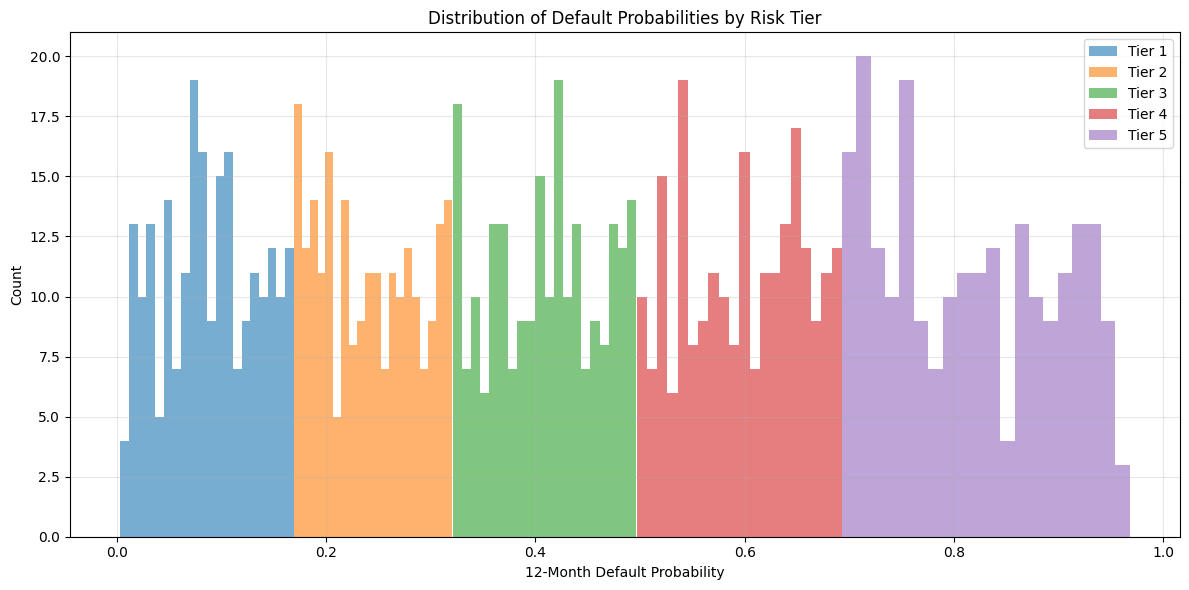

In [22]:
# Plot default probability distribution by risk tier
plt.figure(figsize=(12, 6))
for tier in sorted(tiered_df['risk_tier'].unique()):
    tier_data = tiered_df[tiered_df['risk_tier'] == tier]['default_prob_12m']
    plt.hist(tier_data, alpha=0.6, bins=20, label=tier)

plt.xlabel('12-Month Default Probability')
plt.ylabel('Count')
plt.title('Distribution of Default Probabilities by Risk Tier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
import pickle

# Assuming rsf_pipeline is your trained pipeline
with open('../models/rsf_pipeline.pkl', 'wb') as f:
    pickle.dump(rsf_pipeline, f)